In [1]:
import torch
import sys
import os
os.environ["K_DIFFUSION_USE_COMPILE"] = "0"

import k_diffusion as K
import torch._C._onnx as _C_onnx
from torchinfo import summary
import cv2
import numpy as np
import torchvision

import pynvml
# import onnxruntime as ort
import os
import torch.nn as nn
from PIL import Image

/home/ubuntu/tdist-flat/tdist-regular/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = "/home/ubuntu/tdist-flat/configs/hdit_shifted_window.json"
config = K.config.load_config(config)

model = K.config.make_model(config).cuda()


dct = torch.load("/home/ubuntu/tdist-flat/pix2pixHD/checkpoints/og-reg-4/epoch_3_netG.pth")
dct = {key.replace('model.', ''): value for key, value in dct.items()}

# Find unexpected keys
model_keys = set(model.state_dict().keys())
unexpected_keys = {key: value for key, value in dct.items() if key not in model_keys}

# Print or log the unexpected keys
print("Unexpected keys:", unexpected_keys.keys())

# Optionally, you can remove them before loading the state_dict
filtered_dct = {key: value for key, value in dct.items() if key in model_keys}

# Load the filtered state_dict
model.load_state_dict(filtered_dct, strict=False)

final_activation_function = nn.Tanh()
print(sum([p.numel() for p in model.parameters()]) / 1e6)
model.eval()

img = torch.randn(1,7,1024,1024).cuda()

cst = torch.ones((img.shape[0])).cuda() * 500
with torch.no_grad(): out = final_activation_function(model(img, cst)[0])

out = out / 2. + .5
# raise ValueError(out.shape)
out = out.squeeze(0).transpose(0, 1).transpose(1, 2)
out = Image.fromarray((out.data.cpu().numpy() * 255.).astype(np.uint8))
out.save('out_shifted.png')

/tmp/ipykernel_855829/63585532.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dct = torch.load("/home/ubuntu/tdist-flat/pix2pixHD/checkpoints/og-reg-4/epoch_3_netG.pth"

Unexpected keys: dict_keys(['alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5', 'alpha_sum', 'projector1.weight', 'projector2.weight', 'projector3.weight', 'projector4.weight', 'projector5.weight'])
85.087492


In [3]:
class MyModel(torch.nn.Module):
    def __init__(self, model, device):
        super(MyModel, self).__init__()
        # Example: simple linear layer
        self.cst = torch.ones((1)).to(device) *500
        self.model = model

    def forward(self, img):
        x  = self.model(img,self.cst)
        return x

In [4]:
model.eval()

pmodel = MyModel(model, 'cuda')
pmodel = pmodel
of = '/home/ubuntu/newdata-ps4.onnx'
# input = torch.load("/home/ubuntu/transformer-distillation/tensor_14.pt").unsqueeze(0).cuda()
# input = input.permute(0,2,3,1)
input = torch.rand(1,13,1024,1024).cpu()
torch.onnx.export(pmodel.cuda(), (input.cuda()), of,do_constant_folding=True, export_params=True,input_names = ['input'],output_names = ['output'], verbose=False)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (65536x208 and 112x128)

In [6]:
import os.path
import os
from PIL import Image
import torch
import numpy as np
import torch.nn.functional as F
from torchvision import transforms

max_depth = 4.875197323201151 #log1p(130)


dir_reflection = "/home/ubuntu/utah/Forge1/Reflections/"
reflection_paths = [dir_reflection + x for x in sorted(os.listdir(dir_reflection))]


dir_depth = "/home/ubuntu/utah/Forge1/Depths/"
depth_paths = [dir_depth + x for x in sorted(os.listdir(dir_depth))]

dir_normal = "/home/ubuntu/utah/Forge1/Normals/"
normal_paths = [dir_normal + x for x in sorted(os.listdir(dir_normal))]

dir_diffuse = "/home/ubuntu/utah/Forge1/Diffuses/"
diffuse_paths = [dir_diffuse + x for x in sorted(os.listdir(dir_diffuse))]

dir_radiance = "/home/ubuntu/utah/Forge1/Radiances/"
radiance_paths = [dir_radiance + x for x in sorted(os.listdir(dir_radiance))]


num = 4748
depth_path = dir_depth+ f'{num:06d}-depth.bin'
normal_path = dir_normal+ f'{num:06d}-normal.bin'
diffuse_path = dir_diffuse+ f'{num:06d}-diffuse.png'
reflection_path = dir_reflection+ f'{num:06d}-reflection.png'
radiance_path = dir_radiance+ f'{num:06d}-radiance.png'

print(depth_path, normal_path, diffuse_path, reflection_path, radiance_path)

depth =  np.log1p(np.fromfile(depth_path, dtype='float32').reshape(1024, 1024)) / max_depth
normal = np.fromfile(normal_path, dtype='float16', count=1024*1024*4).reshape(1024, 1024, -1)

depth = torch.from_numpy(depth)
normal = torch.from_numpy(normal)

diffuse = Image.open(diffuse_path)
reflection = Image.open(reflection_path)        
radiance = Image.open(radiance_path)

transform_A = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
diffuse_tensor = transform_A(diffuse.convert('RGB'))
reflection_tensor = transform_A(reflection.convert('RGB'))
radiance_tensor = transform_A(radiance.convert('RGB'))

A_tensor = torch.cat((diffuse_tensor,reflection_tensor,radiance_tensor, 
                        depth.reshape(1,1024,1024).to(diffuse_tensor.dtype), 
                        normal[:,:,:3].permute(2,0,1).to(diffuse_tensor.dtype)))


# if using channel-last format:
# A_tensor = A_tensor.permute(1,2,0)
input_tensor2 = A_tensor.unsqueeze(0) # add batch dimension

/home/ubuntu/utah/Forge1/Depths/004748-depth.bin /home/ubuntu/utah/Forge1/Normals/004748-normal.bin /home/ubuntu/utah/Forge1/Diffuses/004748-diffuse.png /home/ubuntu/utah/Forge1/Reflections/004748-reflection.png /home/ubuntu/utah/Forge1/Radiances/004748-radiance.png


In [ ]:

cst = torch.ones((img.shape[0])).cuda() * 500
with torch.no_grad(): out = final_activation_function(model(img, cst)[0])

out = out / 2. + .5
# raise ValueError(out.shape)
out = out.squeeze(0).transpose(0, 1).transpose(1, 2)
out = Image.fromarray((out.data.cpu().numpy() * 255.).astype(np.uint8))
out.save('out_shifted.png')

In [12]:
config = "/home/ubuntu/tdist-flat/configs/flat-transformers/og-max-32.json"
config = K.config.load_config(config)

model = K.config.make_model(config).cuda()

dct = torch.load("/home/ubuntu/tdist-flat/pix2pixHD/checkpoints/flat-standard-newdata/epoch_12_netG.pth")
dct = {key.replace('model.', ''): value for key, value in dct.items()}

# Find unexpected keys
model_keys = set(model.state_dict().keys())
unexpected_keys = {key: value for key, value in dct.items() if key not in model_keys}

# Print or log the unexpected keys
print("Unexpected keys:", unexpected_keys.keys())

# Optionally, you can remove them before loading the state_dict
filtered_dct = {key: value for key, value in dct.items() if key in model_keys}

# Load the filtered state_dict
model.load_state_dict(filtered_dct, strict=False)

final_activation_function = nn.Tanh()
print(sum([p.numel() for p in model.parameters()]) / 1e6)
model.eval()

img = torch.cat([input_tensor, input_tensor2]).cuda()

cst = torch.ones((img.shape[0])).cuda() * 500
with torch.no_grad(): out = final_activation_function(model(img, cst)[1])

out = out / 2. + .5
out = out.squeeze(0).transpose(0, 1).transpose(1, 2)
out = Image.fromarray((out.data.cpu().numpy() * 255.).astype(np.uint8))
out.save('input_t2_bs2.png')

proj shape = torch.Size([128, 208]) 
 out_features = 128 
 other_dim = 208


proj shape = torch.Size([256, 512]) 
 out_features = 256 
 other_dim = 512
proj shape = torch.Size([384, 1024]) 
 out_features = 384 
 other_dim = 1024
proj shape = torch.Size([768, 1536]) 
 out_features = 768 
 other_dim = 1536
proj shape = torch.Size([1024, 3072]) 
 out_features = 1024 
 other_dim = 3072


/tmp/ipykernel_712021/4262192093.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dct = torch.load("/home/ubuntu/tdist-flat/pix2pixHD/checkpoints/flat-standard-newdata/ep

Unexpected keys: dict_keys(['alpha1', 'alpha2', 'alpha3', 'alpha4', 'alpha5', 'alpha_sum', 'projector1.weight', 'projector2.weight', 'projector3.weight', 'projector4.weight', 'projector5.weight'])
145.450244


In [36]:
(reflection_tensor == new_reflection).all()

tensor(False)

In [15]:
to_tensor = transforms.ToTensor()




NameError: name 'image' is not defined

In [33]:
import matplotlib.pyplot as plt

In [6]:
cst = torch.ones((img.shape[0])).cuda() * 500
out.shape


torch.Size([3, 1024, 1024])

In [7]:
cst = torch.ones((img.shape[0])).cuda() * 500
out2.shape


torch.Size([3, 1024, 1024])

In [12]:
# torch.set_default_tensor_type(torch.FloatTensor)


In [3]:
torch.set_float32_matmul_precision('high')
t1 = torch.randn(1,7,1024,1024).cuda()
t2 = torch.randn(1,7,1024,1024).cuda()
t3 = torch.cat([t1,t2], dim=0)
with torch.no_grad(): out = final_activation_function(model(t1, cst)[0])
with torch.no_grad(): out2 = final_activation_function(model(t3, cst)[0])
absolute_diff = torch.abs(out2 - out)
print("Maximum error using 'high' fp32 precision:",absolute_diff.max())

torch.set_float32_matmul_precision('highest')
with torch.no_grad(): out = final_activation_function(model(t1, cst)[0])
with torch.no_grad(): out2 = final_activation_function(model(t3, cst)[0])
absolute_diff = torch.abs(out2 - out)
print("Maximum error using 'highest' fp32 precision:",absolute_diff.max())

model = model.double()
with torch.no_grad(): out = final_activation_function(model(t1.double(), cst.double())[0])
with torch.no_grad(): out2 = final_activation_function(model(t3.double(), cst.double())[0])
absolute_diff = torch.abs(out2 - out)
print("Maximum error using double precision:",absolute_diff.max())



Maximum error using 'high' fp32 precision: tensor(0.0026, device='cuda:0')
Maximum error using 'highest' fp32 precision: tensor(3.6061e-06, device='cuda:0')
Maximum error using double precision: tensor(1.0603e-14, device='cuda:0', dtype=torch.float64)


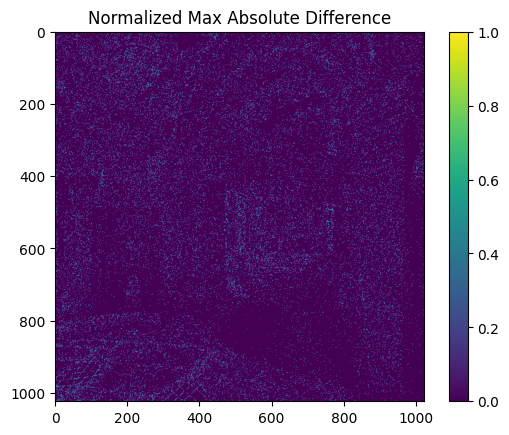

In [1]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms

# Load the images as tensors
B1 = transforms.ToTensor()(Image.open('/home/ubuntu/tdist-flat/input_t1_bs1.png'))
B2 = transforms.ToTensor()(Image.open('/home/ubuntu/tdist-flat/input_t1_bs2.png'))

# Compute the absolute difference
absolute_diff = torch.abs(B1 - B2)
print()
# Normalize the difference by dividing by the max value
normalized_diff = absolute_diff / absolute_diff.max()

# Convert the normalized difference back to a PIL image for display
absolute_diff_pil = transforms.ToPILImage()(normalized_diff)

normed = absolute_diff.max(dim=0)[0] / absolute_diff.max(dim=0)[0].max()
# Plot the normalized absolute difference
plt.imshow((normed))  # permuting to (height, width, channels)
plt.colorbar()
plt.title("Normalized Max Absolute Difference")
plt.savefig('diff.png')

In [2]:
B1

tensor([[[0.0980, 0.1059, 0.1020,  ..., 0.1529, 0.0824, 0.0353],
         [0.0863, 0.0902, 0.0706,  ..., 0.0510, 0.0275, 0.0196],
         [0.0863, 0.1176, 0.0745,  ..., 0.0314, 0.0196, 0.0235],
         ...,
         [0.7216, 0.7098, 0.8353,  ..., 0.0039, 0.0078, 0.0039],
         [0.7176, 0.5843, 0.6157,  ..., 0.0039, 0.0118, 0.0078],
         [0.7216, 0.7569, 0.6588,  ..., 0.0000, 0.0039, 0.0039]],

        [[0.0784, 0.0745, 0.0784,  ..., 0.1020, 0.0588, 0.0196],
         [0.0588, 0.0667, 0.0471,  ..., 0.0275, 0.0118, 0.0118],
         [0.0667, 0.1059, 0.0549,  ..., 0.0235, 0.0118, 0.0118],
         ...,
         [0.6588, 0.5686, 0.7608,  ..., 0.0000, 0.0000, 0.0000],
         [0.6039, 0.4235, 0.4510,  ..., 0.0000, 0.0039, 0.0000],
         [0.5373, 0.5451, 0.4706,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0353, 0.0392, 0.0549,  ..., 0.0510, 0.0196, 0.0078],
         [0.0314, 0.0353, 0.0314,  ..., 0.0157, 0.0039, 0.0039],
         [0.0275, 0.0510, 0.0275,  ..., 0.0039, 0.0000, 0.

In [4]:
absolute_diff = torch.abs(B1 - B2)
print(absolute_diff.max())

tensor(0.0039)


In [37]:
num = 41748
new_depth = torch.load(f'/home/ubuntu/depth_{num}.pt')
new_diffuse = torch.load(f'/home/ubuntu/diffuse_{num}.pt')
new_normal = torch.load(f'/home/ubuntu/normal_{num}.pt')
new_radiance = torch.load(f'/home/ubuntu/radiance_{num}.pt')
new_reflection = torch.load(f'/home/ubuntu/reflection_{num}.pt')


/tmp/ipykernel_508643/2336305408.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_depth = torch.load(f'/home/ubuntu/depth_{num}.pt')
/tmp/ipykernel_508643/2336305408.

In [38]:
!pip install onnxruntime

In [39]:
import onnxruntime as ort
import torch
import numpy as np

In [40]:
print(sum([p.numel() for p in pmodel.parameters()]) / 1e6)

145.450244


In [41]:
input_tensor.shape

torch.Size([1, 13, 1024, 1024])

In [42]:
# torch.save(input_tensor, '/home/ubuntu/input.pt')

In [45]:
# input = torch.load('/home/ubuntu/input.pt')
# input = input[3].unsqueeze(0).cuda()

input = input_tensor
# input = input.permute(0,2,3,1)

providers = [
    ('CPUExecutionProvider', {
        'device_id': 0, # The device ID
        # 'trt_max_workspace_size': 4e9, # Maximum workspace size for TensorRT engine (1e9 ≈ 1GB)
        # 'trt_engine_cache_enable': False, # Enable TensorRT engine caching
        # # 'trt_engine_cache_path': str(trt_cache_dir), # Path for TensorRT engine, profile files, and int8 calibration table
        # 'trt_int8_enable': True, # Enable int8 mode in TensorRT
    })
]

# providers = 
#     ('CUDAExecutionProvider')]

sess_options = ort.SessionOptions()
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_DISABLE_ALL
sess_options.enable_mem_pattern = False
sess_options.use_deterministic_compute = True
sess_options.execution_mode = ort.ExecutionMode.ORT_SEQUENTIAL
sess_options.enable_cpu_mem_arena = False



session = ort.InferenceSession("/home/ubuntu/model-quantized.onnx",sess_options,providers=providers)

# Run inference with ONNX Runtime
input_data = input.cpu().numpy().astype(np.float32)
ort_inputs = {session.get_inputs()[0].name: input_data}
# start = torch.cuda.Event(enable_timing=True)
# end = torch.cuda.Event(enable_timing=True)

    # start.record()
onnx_output = session.run(None, ort_inputs)
    # end.record()
    # print(start.elapsed_time(end))
# Compare the outputs

outim = onnx_output[0][0]
outim = np.transpose(outim,(1,2,0))
outim = (torch.tanh(torch.tensor(outim)).numpy() +1)/2.0
out = Image.fromarray((outim * 255.).astype(np.uint8))


out.save('out_shifted2.png')

In [27]:
outim = onnx_output[0][0]
outim = np.transpose(outim,(1,2,0))
outim = (torch.tanh(torch.tensor(outim)).numpy() +1)/2.0
out = Image.fromarray((outim * 255.).astype(np.uint8))


out.save('out_shifted1.png')

In [ ]:
import onnx2keras
from onnx2keras import onnx_to_keras
import keras
import onnx


In [ ]:
out = torch.tanh(torch.tensor(onnx_output[0]))
out = out / 2. + .5


In [ ]:
out = Image.fromarray((outim * 255.).astype(np.uint8))
out.save('out_shifted1.png')

In [5]:
import os

In [10]:
root = '/home/ubuntu/utah/DATASET-11-10-24/TestDataset'

for i in range(44_300,50_000):
    print(os.path.exists(f"{root}/Depths/{i}-depth.bin"))
    try:
        os.rename(f"{root}/Depths/{i}-depth.bin", f"{root}/Depths/{i:06d}-depth.bin")
        os.rename(f"{root}/Normals/{i}-normal.bin", f"{root}/Depths/{i:06d}-normal.bin")
        os.rename(f"{root}/Diffuses/{i}-diffuse.png", f"{root}/Diffuses/{i:06d}-diffuse.png")
        os.rename(f"{root}/Radiances/{i}-radiance.png", f"{root}/Radiances/{i:06d}-radiance.png")
        os.rename(f"{root}/Reflections/{i}-reflection.png", f"{root}/Reflections/{i:06d}-reflection.png")
    except:
        print('failed:',i)
        pass

False
failed: 44300
False
failed: 44301
False
failed: 44302
False
failed: 44303
False
failed: 44304
False
failed: 44305
False
failed: 44306
False
failed: 44307
False
failed: 44308
False
failed: 44309
False
failed: 44310
False
failed: 44311
False
failed: 44312
False
failed: 44313
False
failed: 44314
False
failed: 44315
False
failed: 44316
False
failed: 44317
False
failed: 44318
False
failed: 44319
False
failed: 44320
False
failed: 44321
False
failed: 44322
False
failed: 44323
False
failed: 44324
False
failed: 44325
False
failed: 44326
False
failed: 44327
False
failed: 44328
False
failed: 44329
False
failed: 44330
False
failed: 44331
False
failed: 44332
False
failed: 44333
False
failed: 44334
False
failed: 44335
False
failed: 44336
False
failed: 44337
False
failed: 44338
False
failed: 44339
False
failed: 44340
False
failed: 44341
False
failed: 44342
False
failed: 44343
False
failed: 44344
False
failed: 44345
False
failed: 44346
False
failed: 44347
False
failed: 44348
False
failed: 44349


In [14]:
print(len(os.listdir(f"{root}/Depths")))
print(len(os.listdir(f"{root}/Normals")))
print(len(os.listdir(f"{root}/Diffuses")))
print(len(os.listdir(f"{root}/Radiances")))
print(len(os.listdir(f"{root}/Reflections")))
print(len(os.listdir(f"{root}/UE")))


5649
5649
5649
5649
5649
5649
